In [10]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K

from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from models import Unet_with_slice,Unet_with_inception,Inception,Unet

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image

from utils import dice_coef_loss,dice_coef,one_hot_encode,standardize

In [13]:
input_img = Input((240, 240, 4))
model = Unet(input_img,16,0.1,True)
learning_rate = 0.001
epochs = 5000
decay_rate = learning_rate / epochs
optimizer_legacy = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer_legacy, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 240, 240, 16)         592       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 240, 240, 16)         64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 240, 240, 16)         0         ['batch_normalization_36

                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 128)          0         ['activation_43[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 dropout_17 (Dropout)        (None, 15, 15, 128)          0         ['max_pooling2d_11[0][0]']    
                                                                                                  
 conv2d_46 (Conv2D)          (None, 15, 15, 256)          295168    ['dropout_17[0][0]']          
                                                                                                  
 batch_normalization_44 (Ba  (None, 15, 15, 256)          1024      ['conv2d_46[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 conv2d_53 (Conv2D)          (None, 120, 120, 32)         9248      ['activation_50[0][0]']       
                                                                                                  
 batch_normalization_51 (Ba  (None, 120, 120, 32)         128       ['conv2d_53[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_51 (Activation)  (None, 120, 120, 32)         0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 dropout_20 (Dropout)        (None, 120, 120, 32)         0         ['activation_51[0][0]']       
          

210 Brats17_CBICA_AWH_1
0
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)


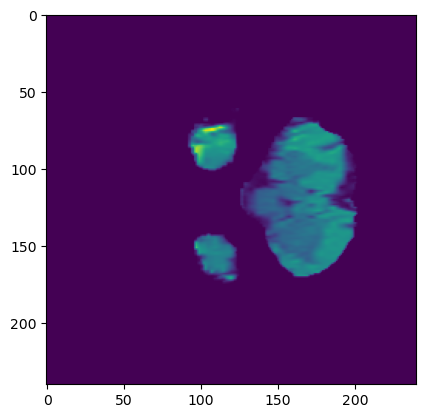

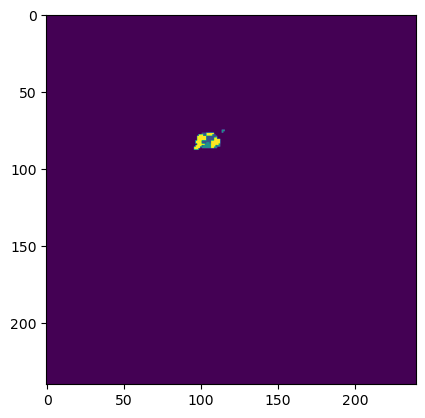

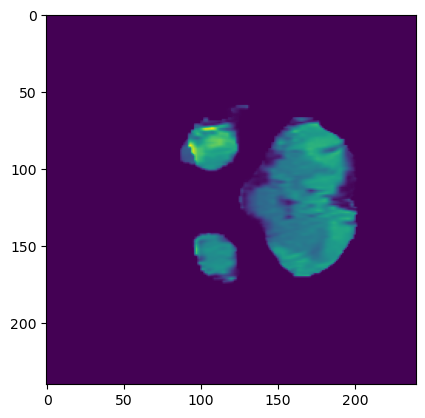

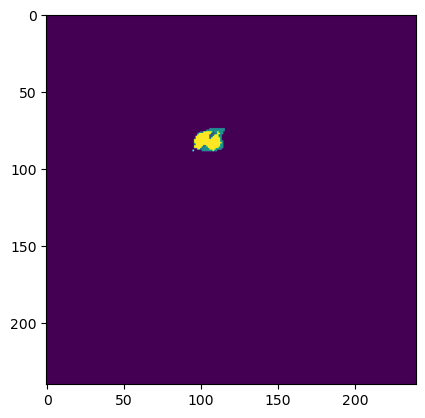

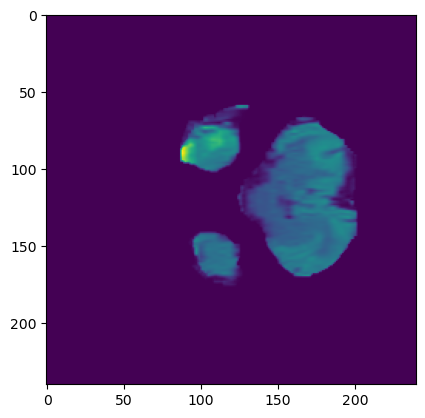

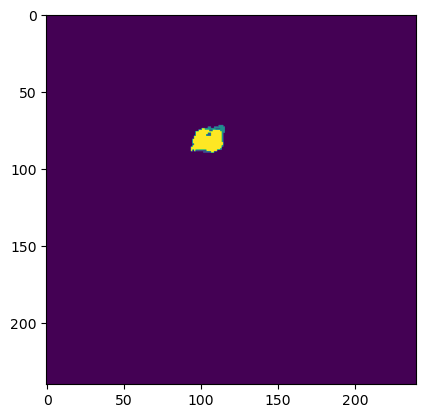

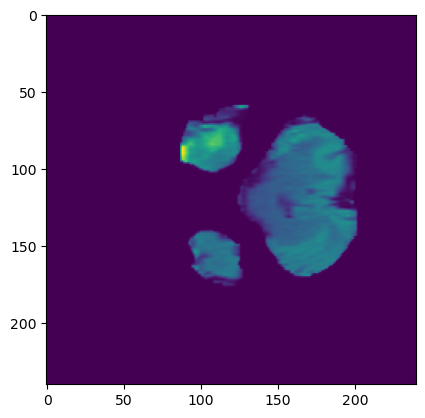

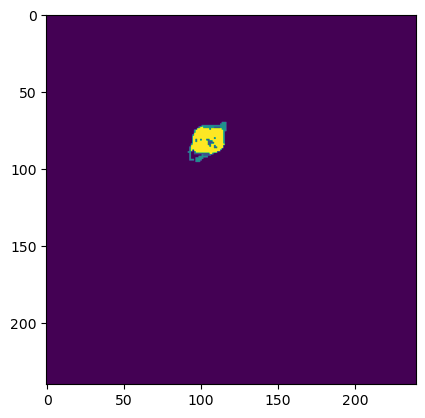

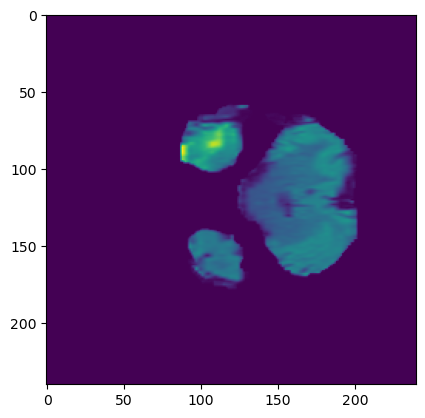

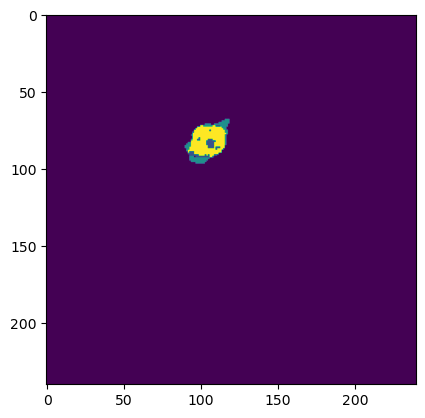

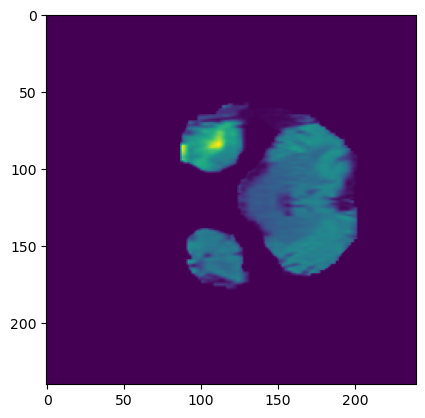

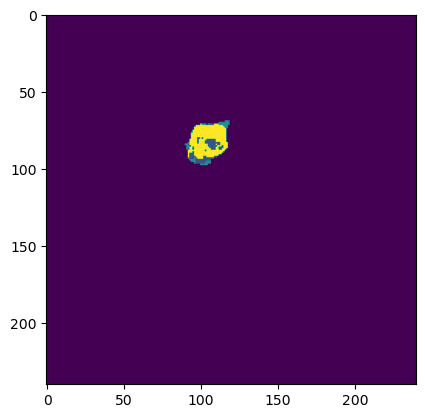

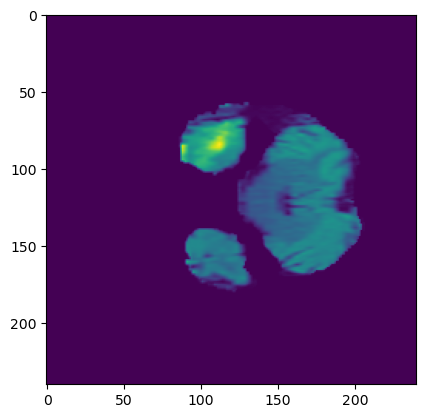

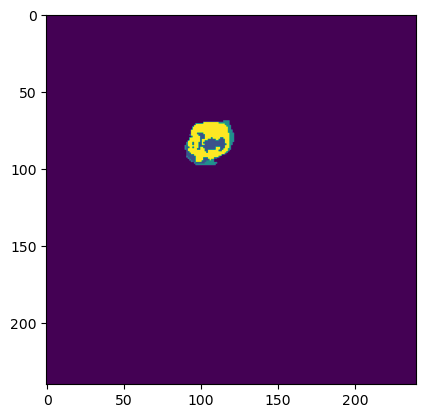

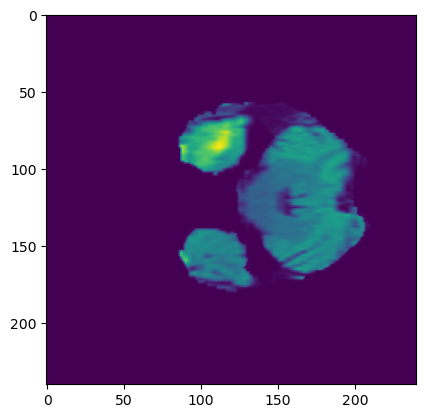

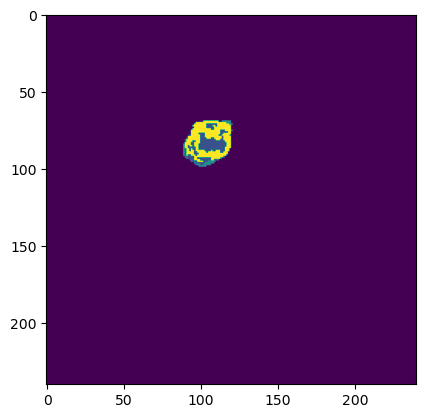

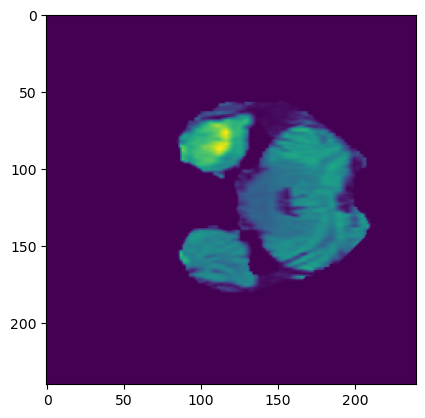

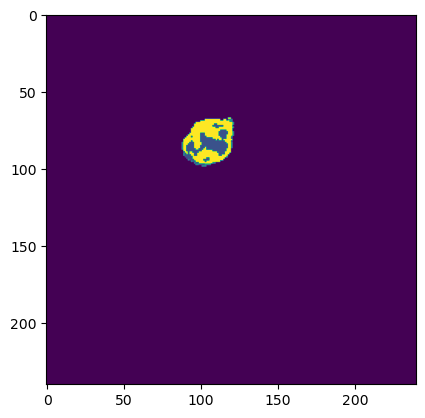

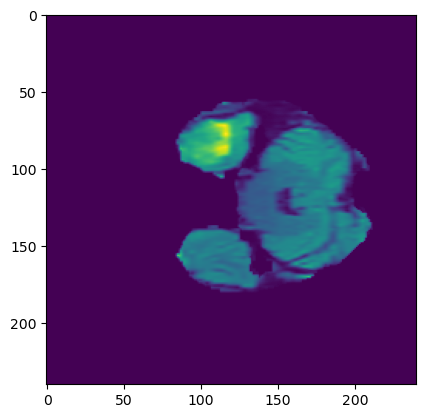

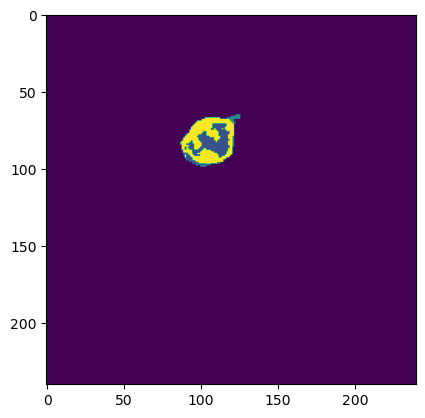

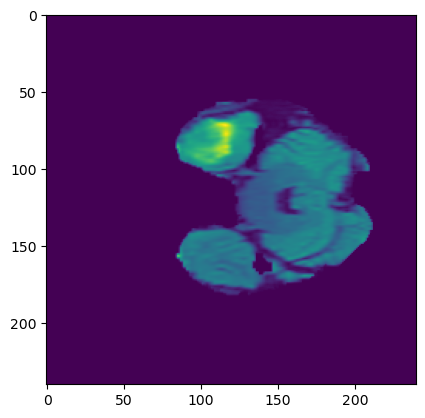

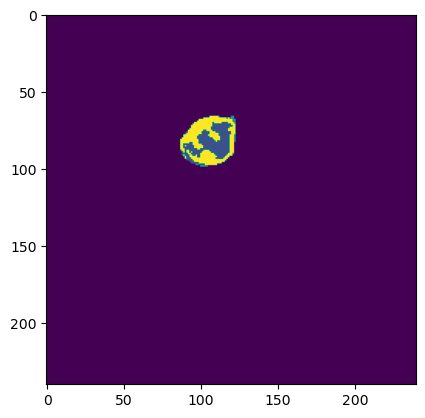

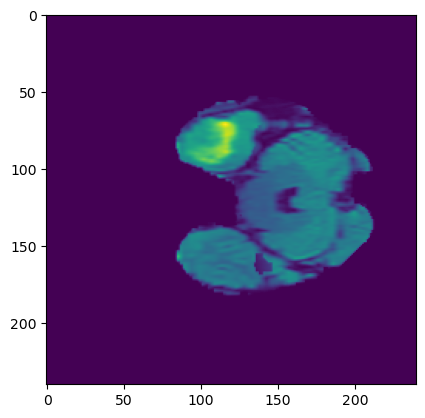

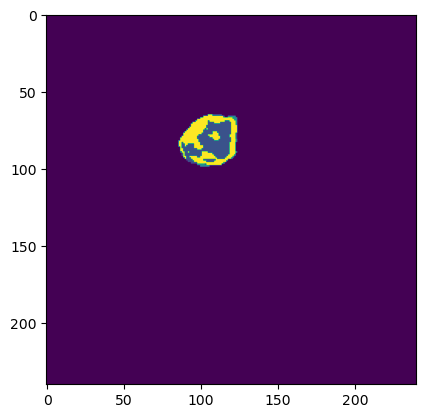

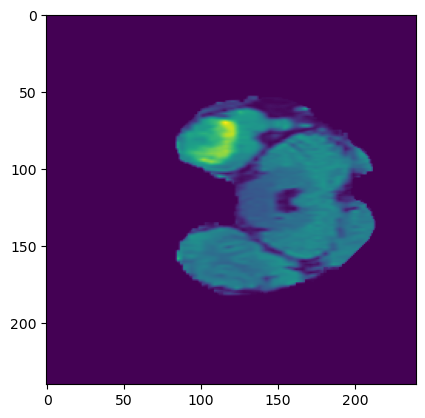

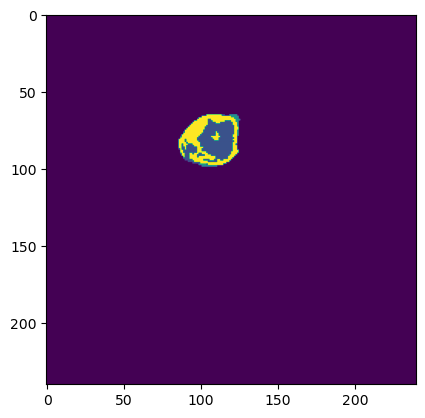

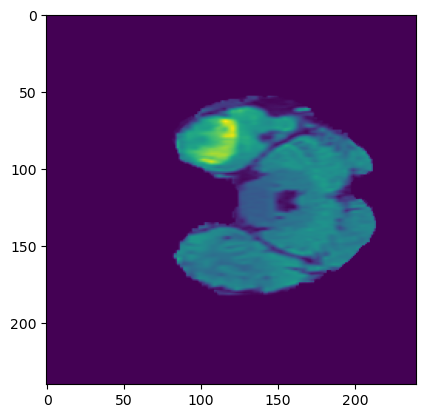

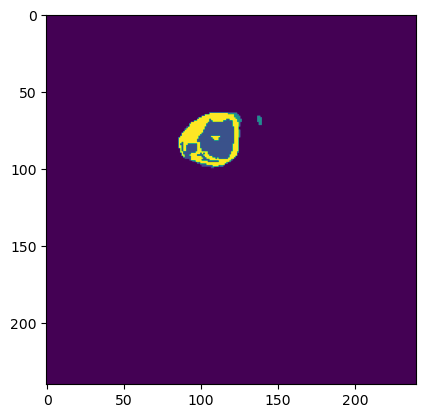

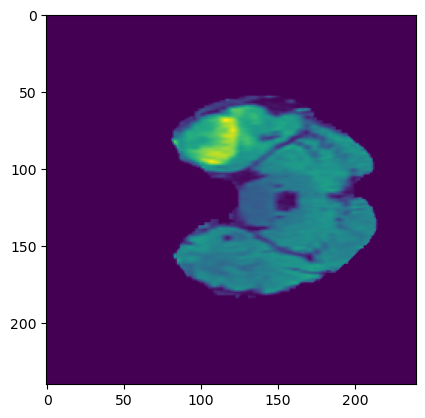

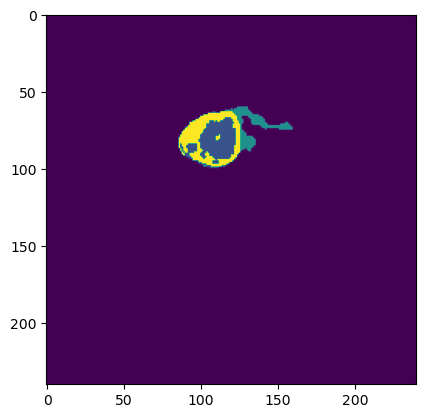

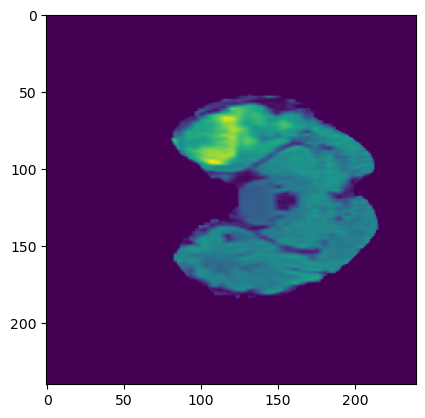

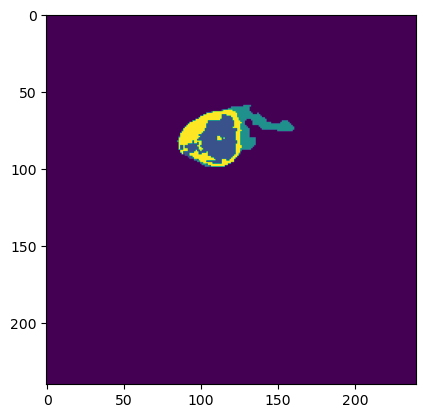

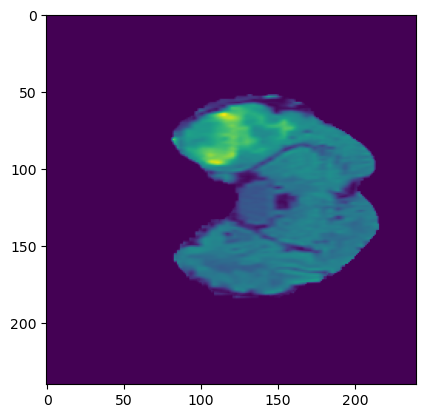

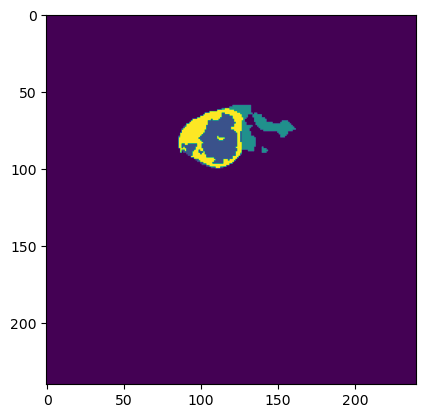

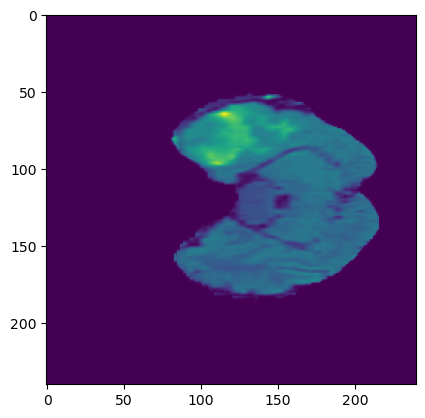

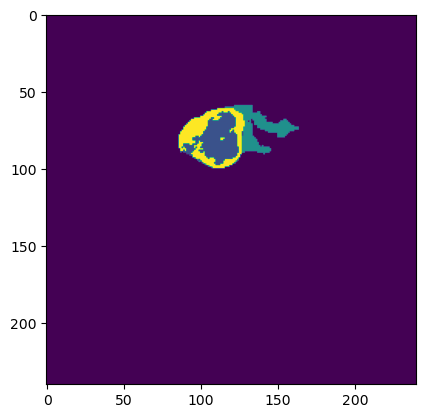

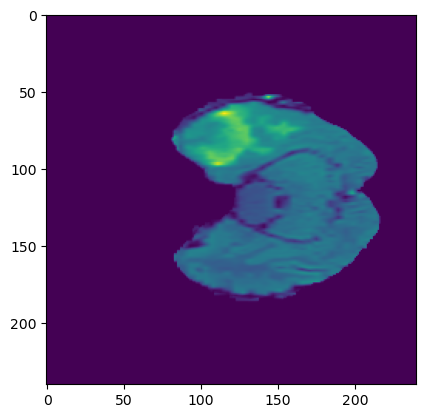

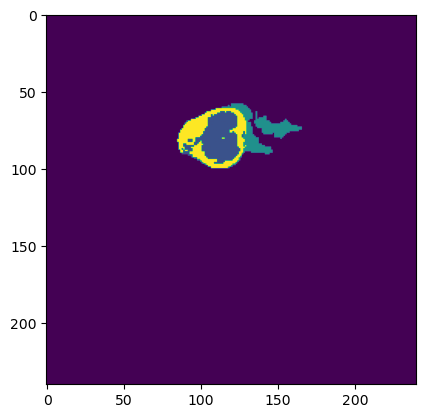

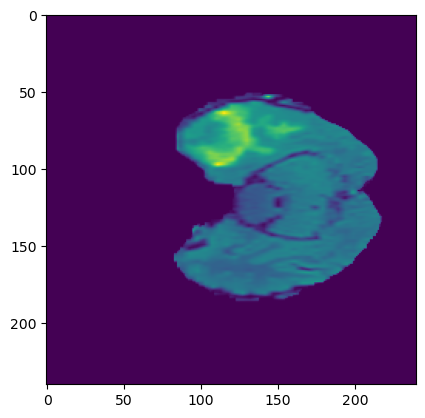

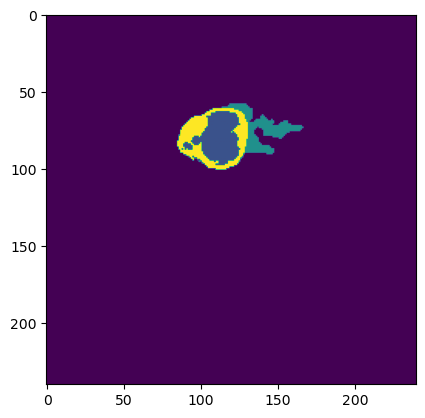

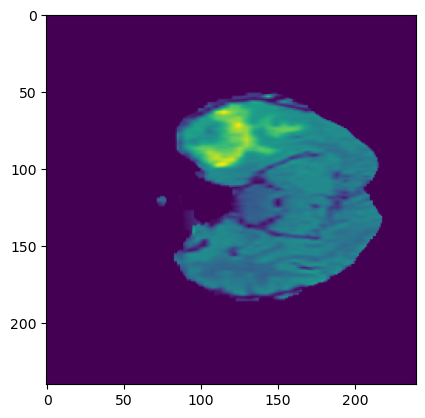

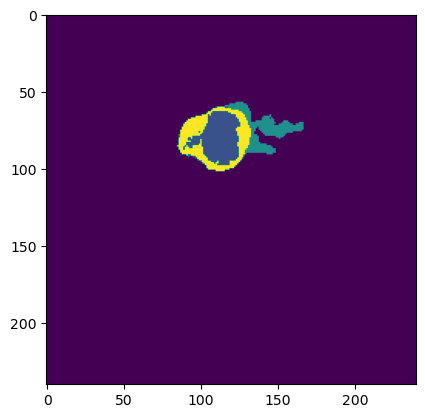

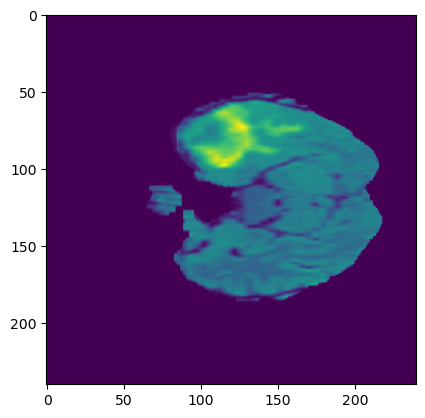

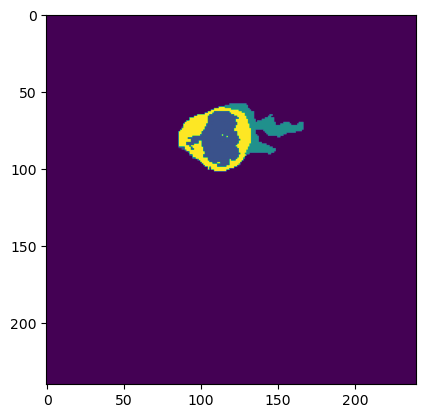

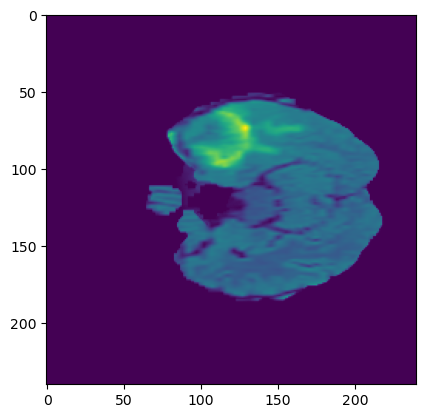

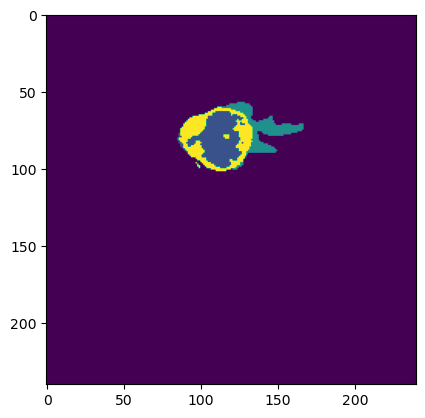

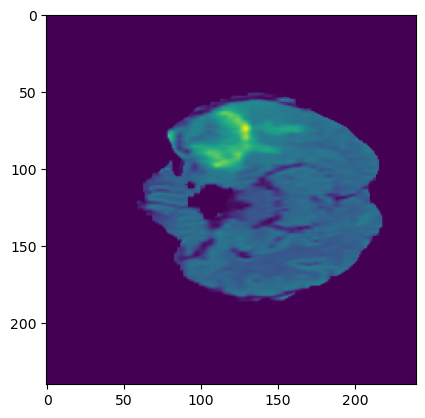

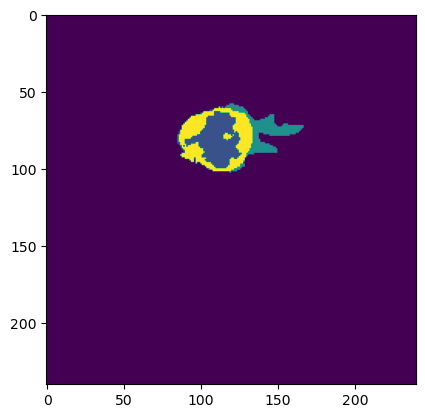

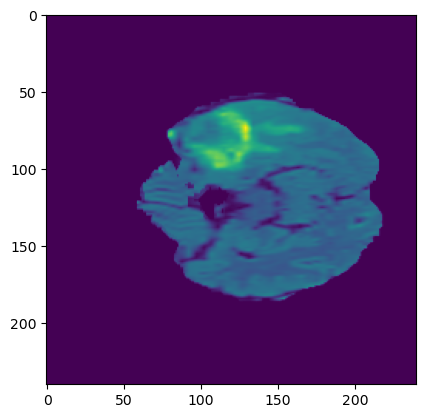

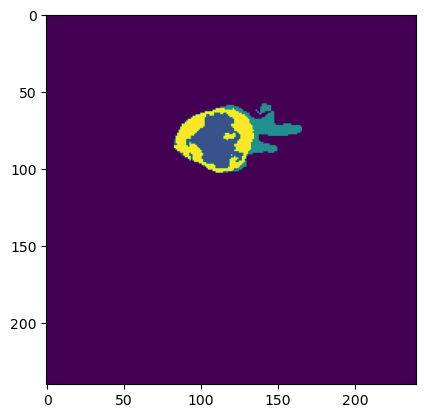

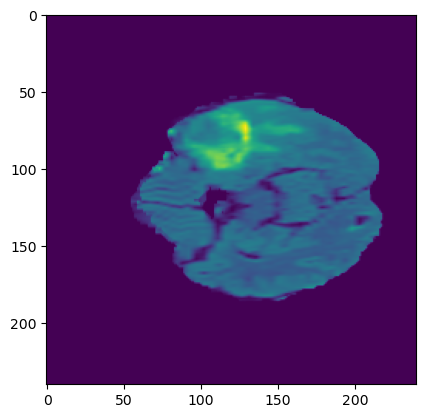

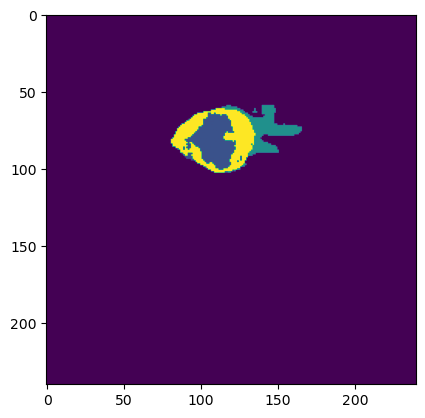

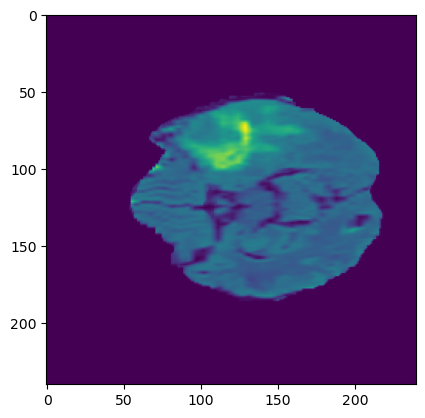

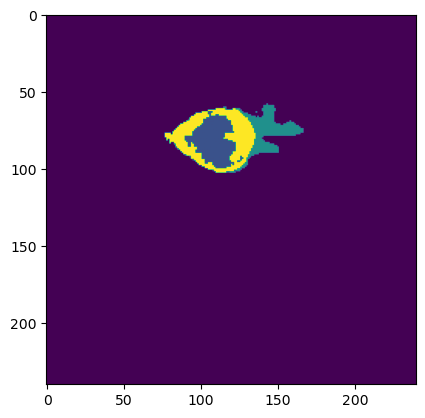

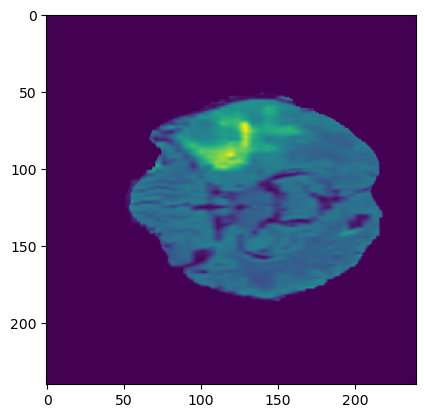

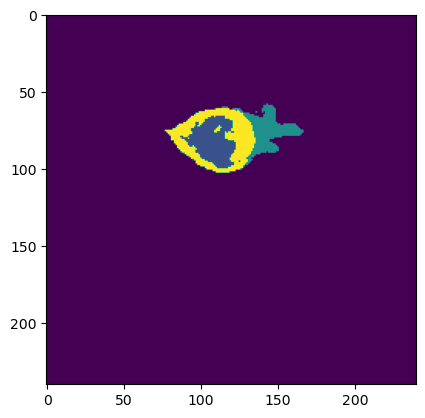

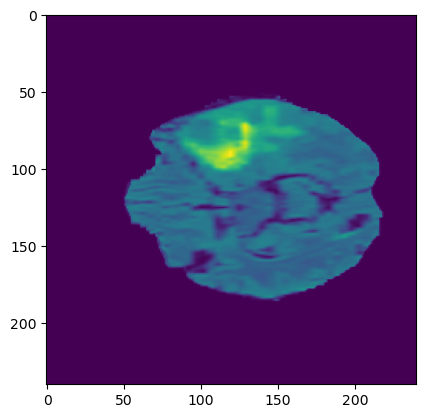

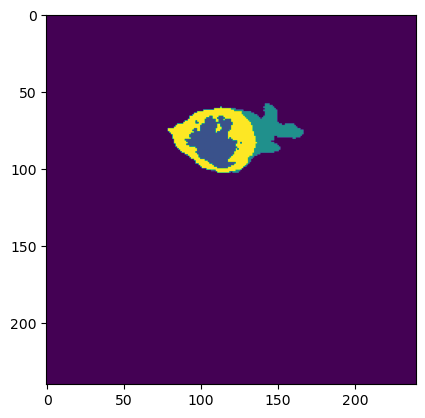

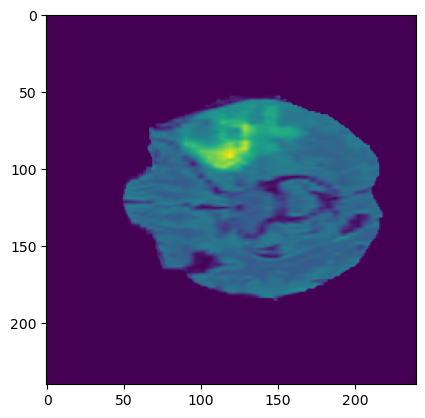

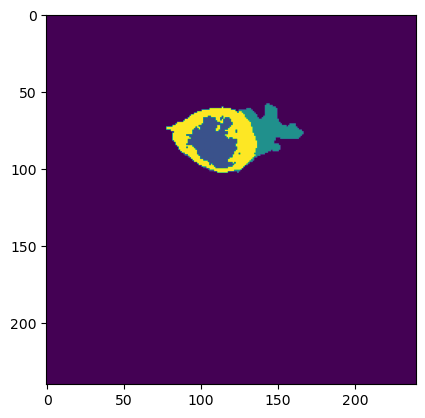

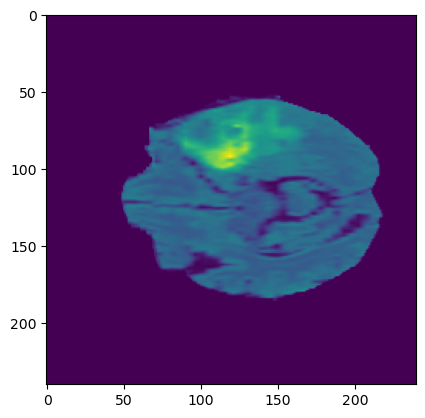

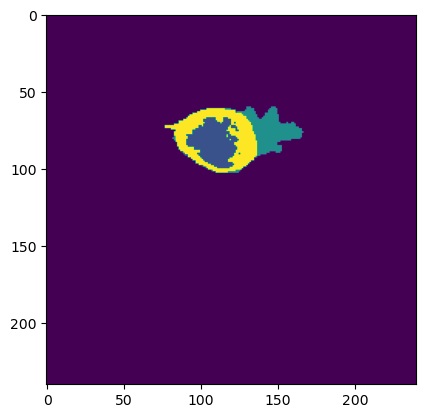

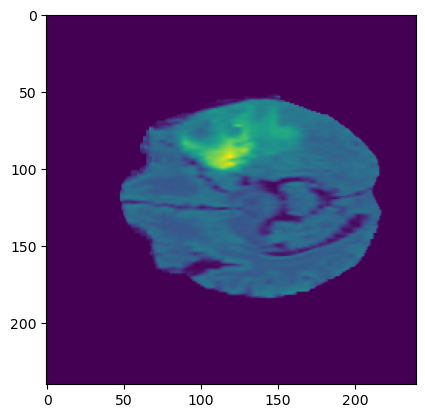

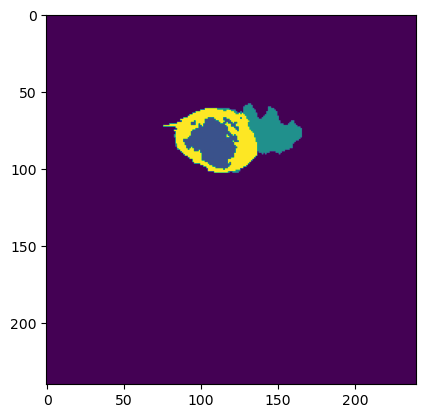

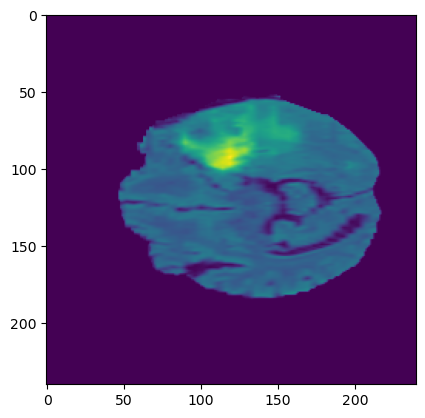

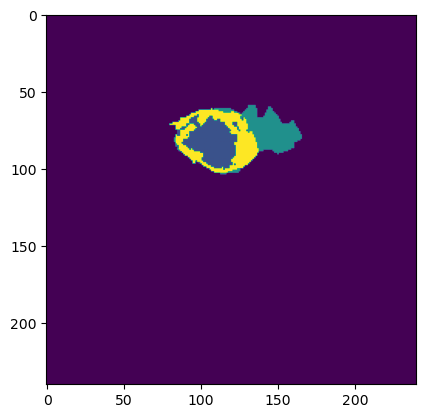

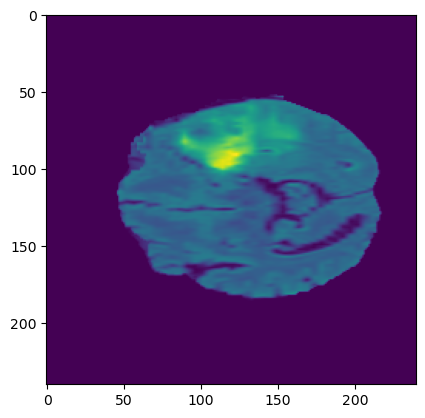

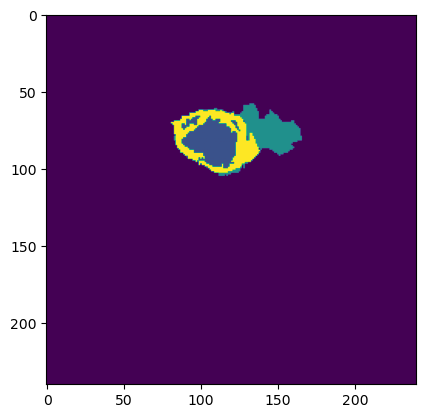

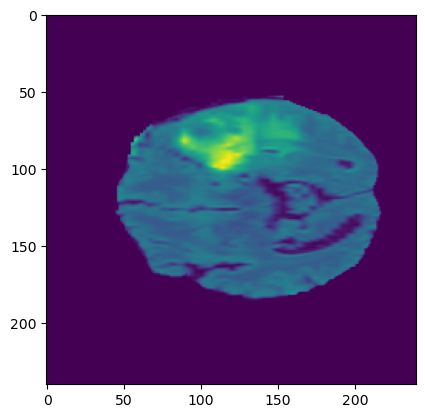

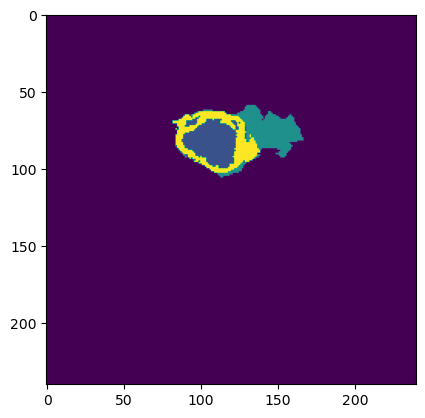

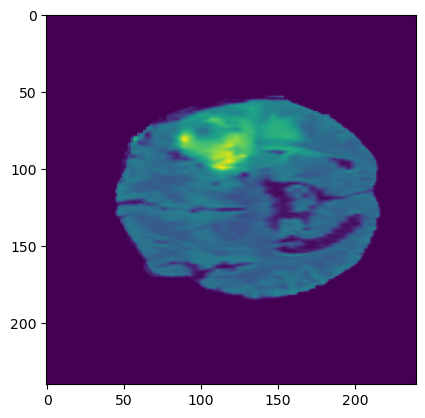

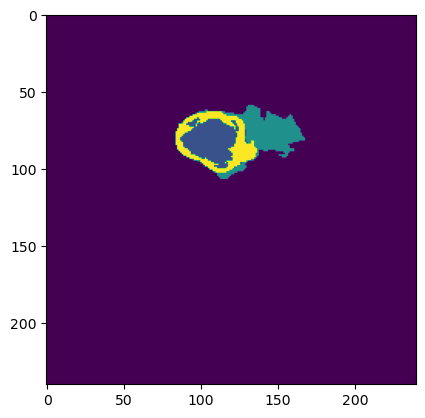

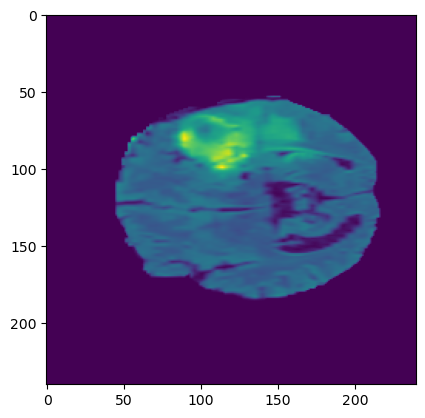

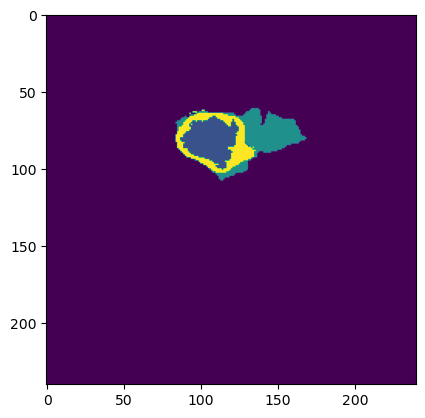

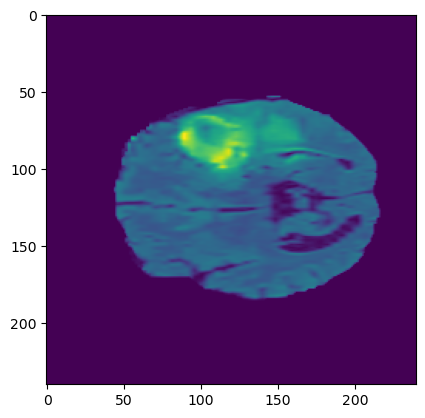

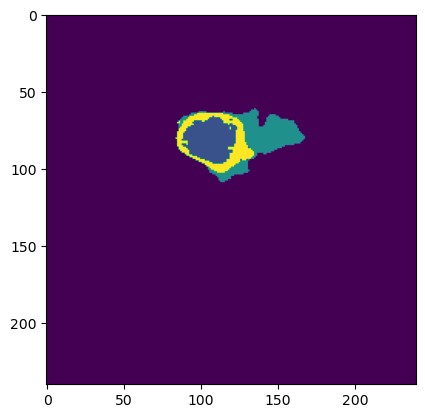

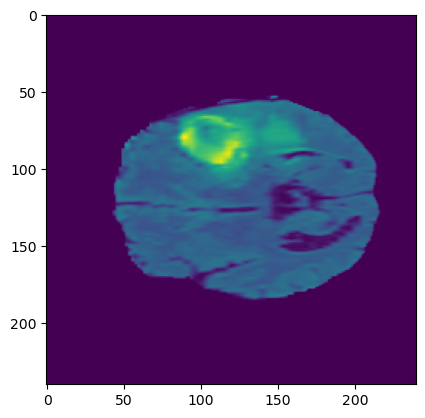

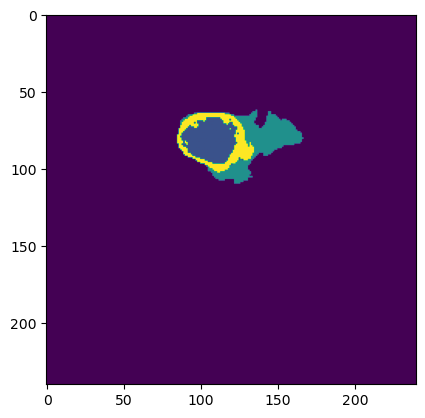

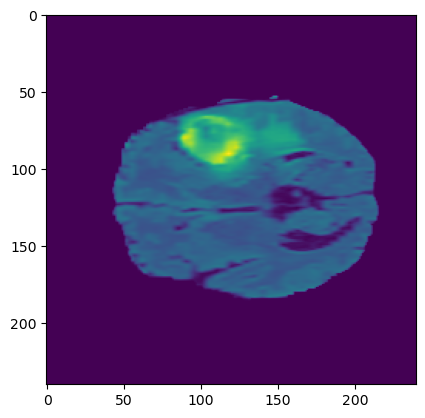

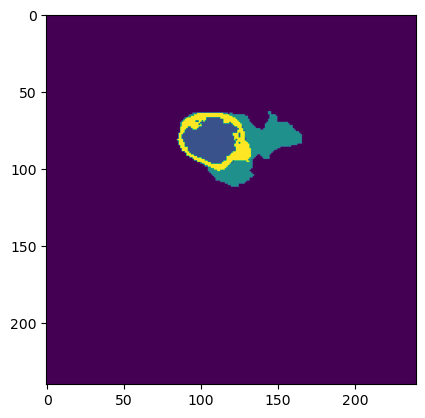

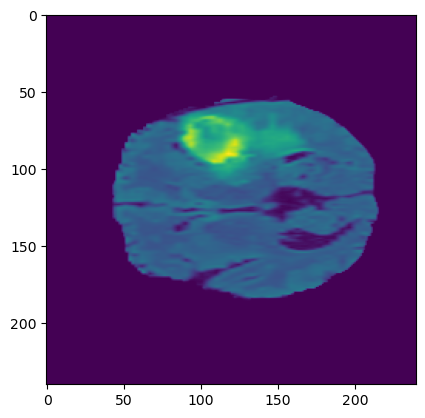

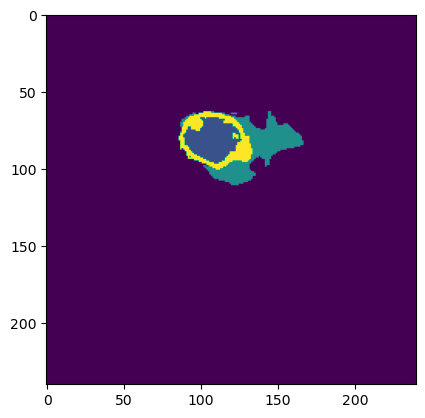

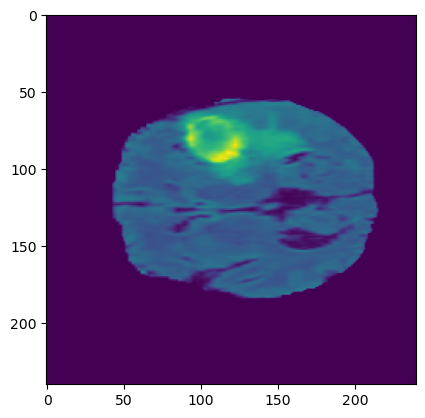

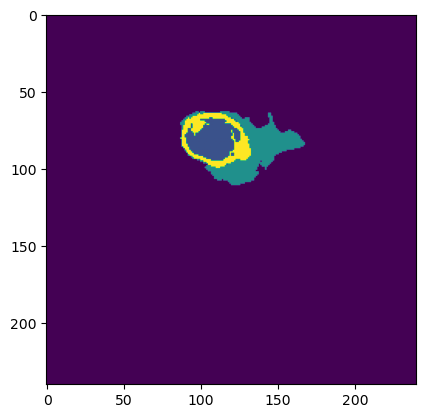

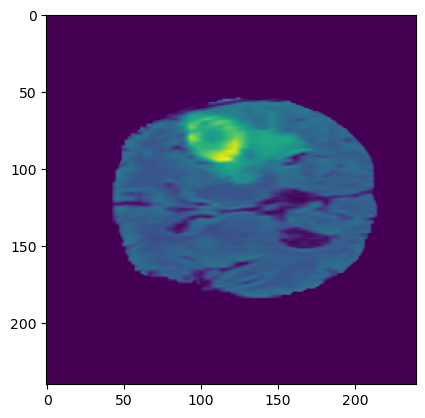

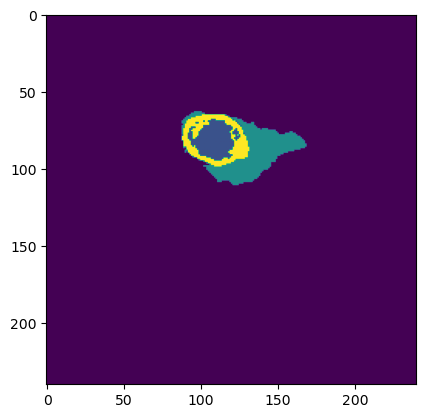

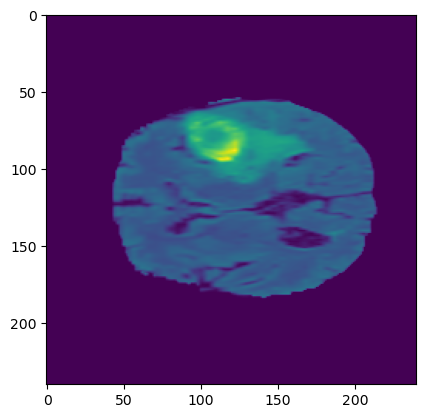

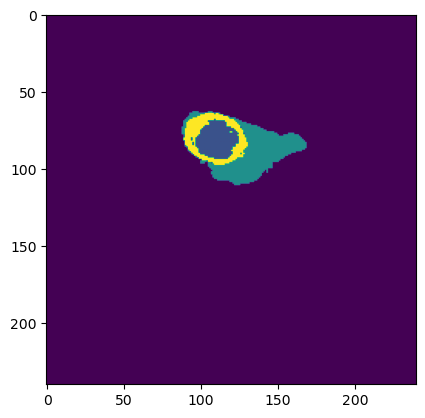

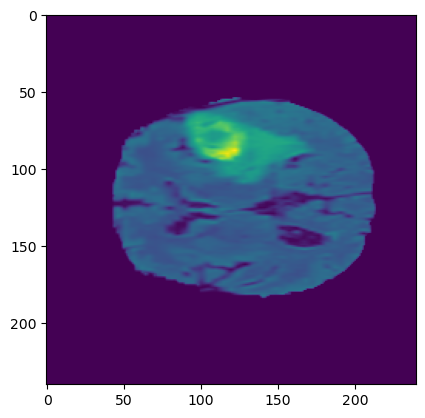

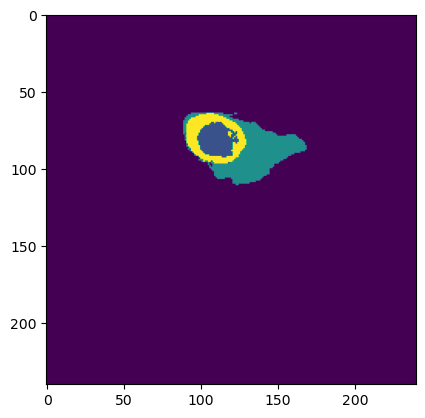

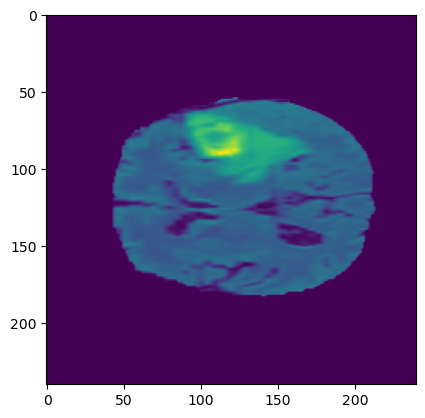

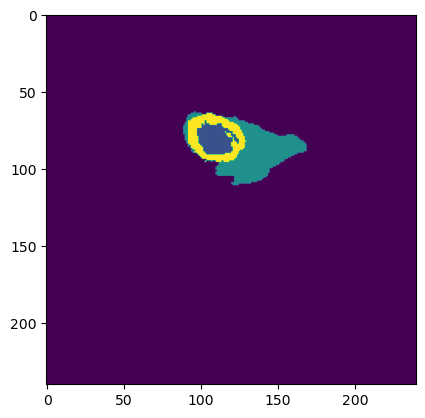

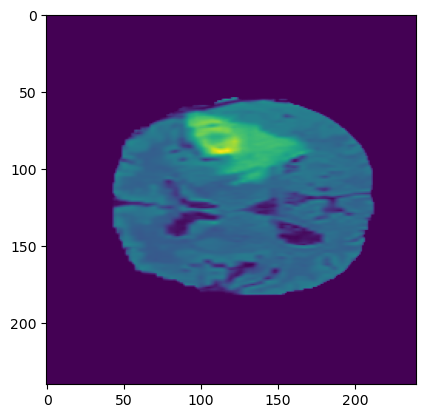

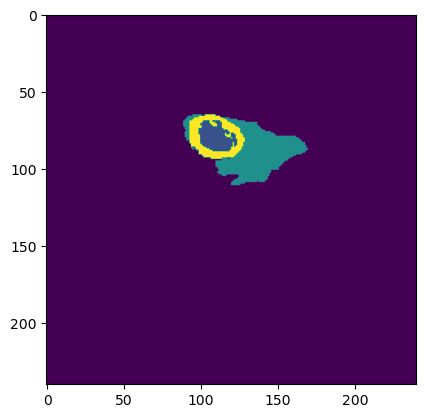

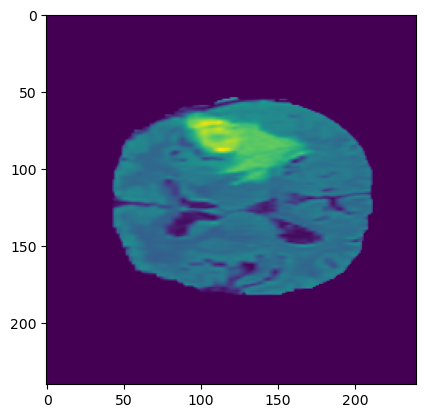

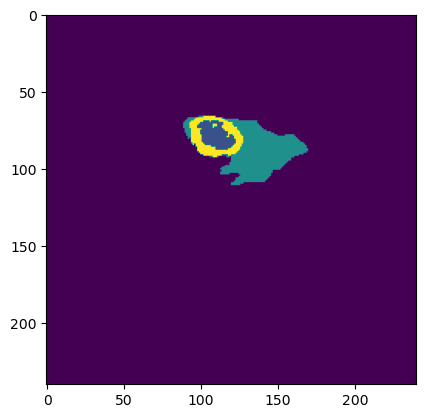

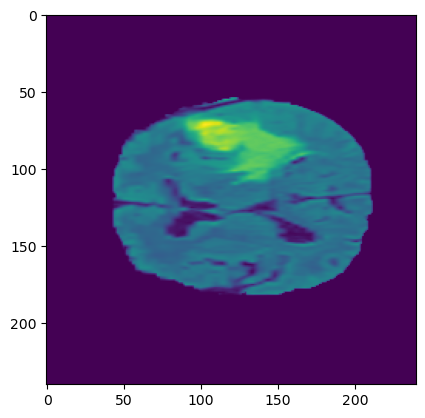

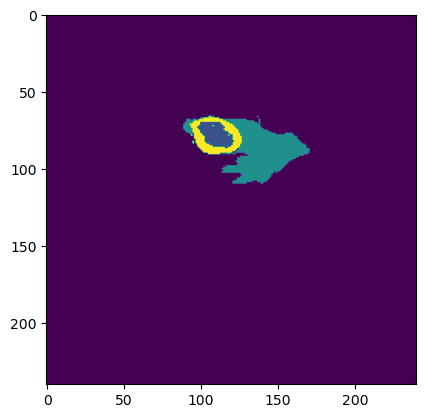

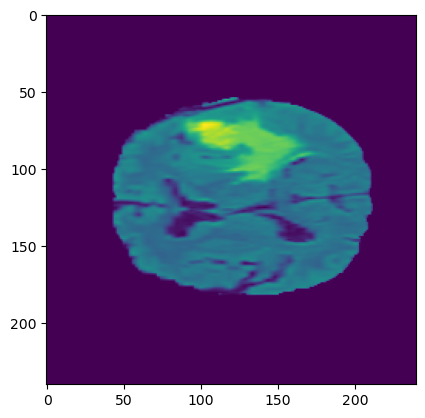

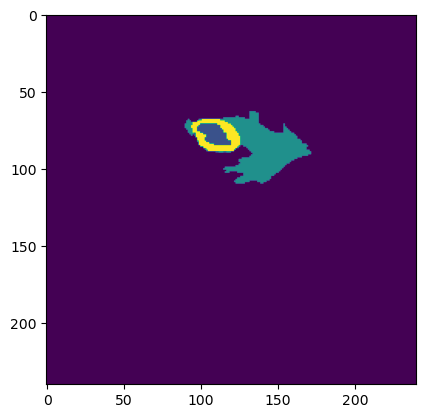

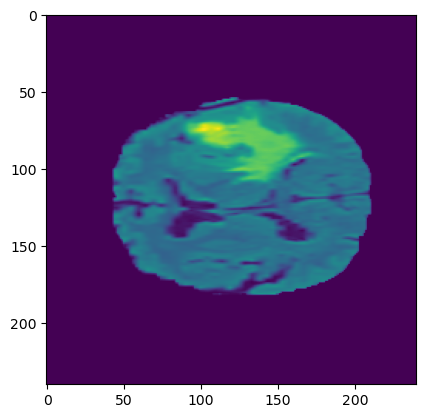

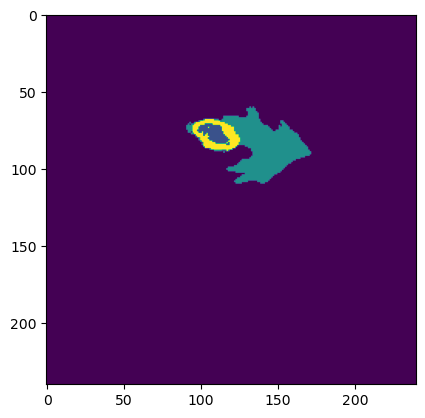

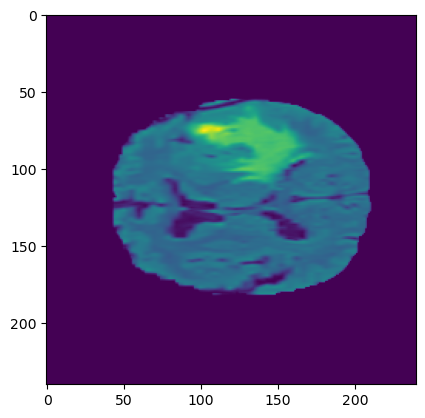

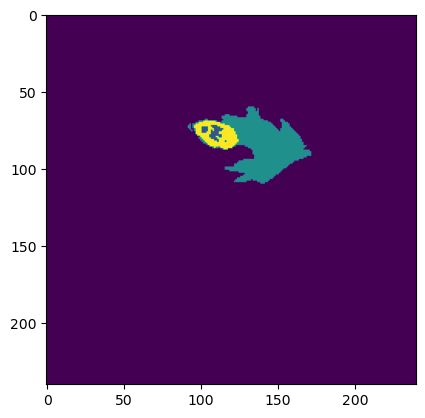

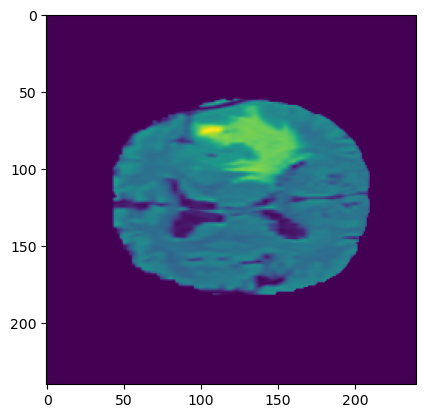

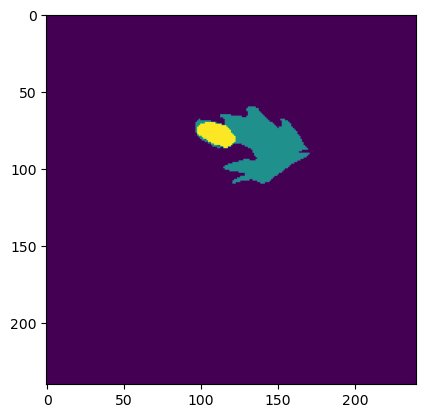

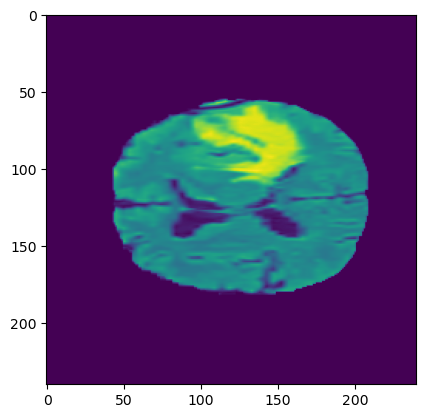

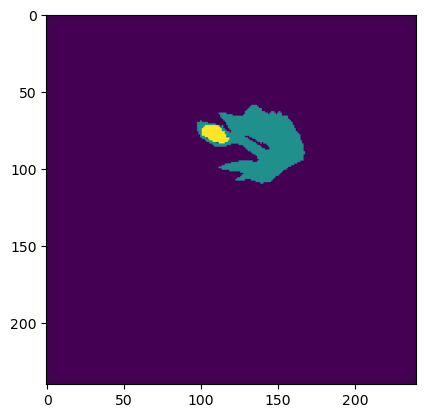

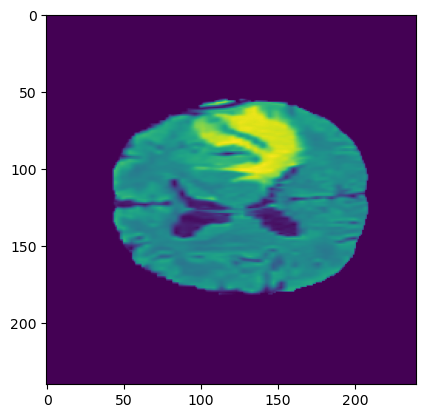

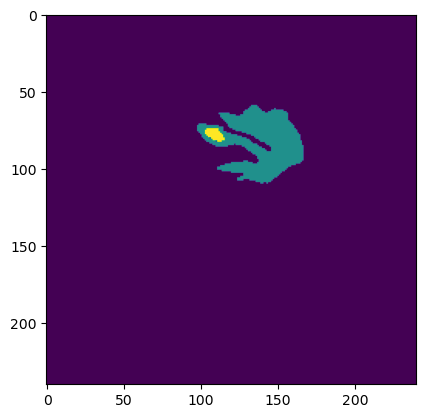

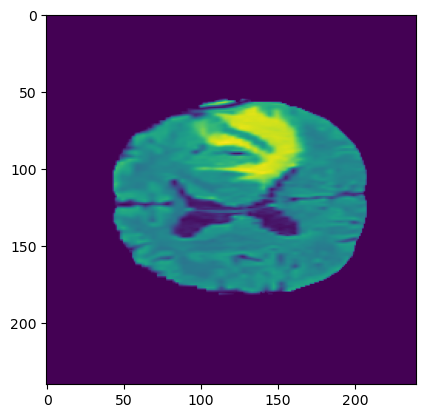

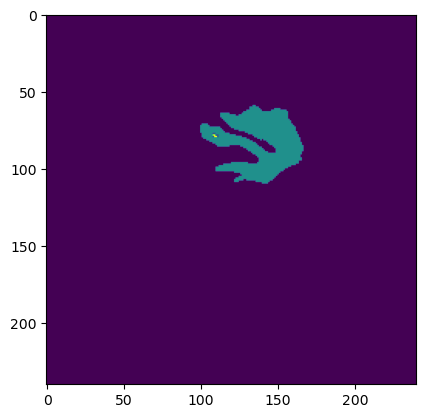

(57, 240, 240, 4)
(57, 240, 240, 1)
(57, 240, 240, 1)
Epoch 1/50
3/3 [==============================] - 895s 1s/step - loss: 0.8548 - dice_coef: 0.1463
Epoch 2/50
3/3 [==============================] - 944s 472s/step - loss: 0.8106 - dice_coef: 0.1911
Epoch 3/50
3/3 [==============================] - 936s 467s/step - loss: 0.7770 - dice_coef: 0.2236
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 0.7389 - dice_coef: 0.2626
Epoch 5/50
3/3 [==============================] - 1076s 537s/step - loss: 0.7006 - dice_coef: 0.3002
Epoch 6/50
3/3 [==============================] - 337s 168s/step - loss: 0.6644 - dice_coef: 0.3374
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.6298 - dice_coef: 0.3705
Epoch 8/50
3/3 [==============================] - 1022s 510s/step - loss: 0.6065 - dice_coef: 0.3937
Epoch 9/50
3/3 [==============================] - 4s 1s/step - loss: 0.5856 - dice_coef: 0.4124
Epoch 10/50
3/3 [==============================] - 677s 1s

/Users/mattwalls/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# data preprocessing starts here
path = 'BRATS2017/Brats17TrainingData/HGG'
all_images = os.listdir(path)
print(len(all_images),all_images[0])
all_images.sort()
data = np.zeros((240,240,155,4))
x_to = []
y_to = []
for file in all_images:
    if file == '.DS_Store':
        file_path = os.path.join(path, file)
        os.remove(file_path)
        print(f"Removed {file_path}")

for i in range(1):
    x = all_images[i]
    print(i)
    folder_path = os.path.join(path, x)
    
    if os.path.isdir(folder_path): 
        modalities = os.listdir(folder_path)
        modalities.sort()
        
        # Check for .DS_Store within modalities
        if '.DS_Store' in modalities:
            print(f"Skipping {folder_path} due to .DS_Store")
            continue
        
        for modality in modalities:
            if modality.endswith('.nii'):
                image_path = os.path.join(folder_path, modality)
                try:
                    img = nib.load(image_path)
                    image_data = img.get_fdata()
                    image_data = np.asarray(image_data)
                    # Process image data
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
    else:
        print(f"{folder_path} is not a valid directory.")
    w = 0
    for j in range(len(modalities)-1):
        image_path = folder_path + '/' + modalities[j]
        if(image_path[-7:-1] + image_path[-1] == 'seg.nii'):
          img = nib.load(image_path);
          image_data2 = img.get_fdata()
          image_data2 = np.asarray(image_data2)
          print("Entered ground truth")
        else:
          img = nib.load(image_path)
          image_data = img.get_fdata()
          image_data = np.asarray(image_data)
          image_data = standardize(image_data)
          data[:,:,:,w] = image_data
          print("Entered modality")
          w = w+1
    
    print(data.shape)
    print(image_data2.shape)  

    
    for slice_no in range(0,155):
        a = slice_no
        X = data[:,:,slice_no,:]

        Y = image_data2[:,:,slice_no]
        

        if(X.any()!=0 and Y.any()!=0 and len(np.unique(Y)) == 4):
          
            x_to.append(X)
            y_to.append(Y.reshape(240,240,1))

            imgplot = plt.imshow(X[:,:,0])
            plt.show(block=False)
            plt.pause(100)
            plt.close()
    
            imgplot = plt.imshow(Y)
            plt.show(block=False)
            plt.pause(3)
            plt.close()
    
      
            for l in range(4):
                img = Image.fromarray(X[:,:,l])
                img2 = img.rotate(45)
                rotated = np.asarray(img2)
                X[:,:,l] = rotated
            img = Image.fromarray(Y)
            img2 = img.rotate(45)
            rotated = np.asarray(img2)
            Y = rotated
      
x_to.append(X)
y_to.append(Y.reshape(240,240,1))

x_to = np.asarray(x_to)
y_to = np.asarray(y_to)
print(x_to.shape)
print(y_to.shape)

  
y_to[y_to==4] = 1         #since label 4 was missing in Brats dataset , changing all labels 4 to 3.
#y_to = one_hot_encode(y_to)
y_to[y_to==2] = 1
y_to[y_to==1] = 1
y_to[y_to==0] = 0
print(y_to.shape)
#y_to = y_to.reshape(240,240,1)


  

model.fit(x=x_to, y=y_to, batch_size=20, epochs=50)



model.save('2class.h5')